# TP PERCEPTRON

### Package

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib import cm
import seaborn as sns
from matplotlib import rc

### Display labeled data

In [2]:
symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': '.15',
 'axes.grid': False,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': '.8',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'patch.force_edgecolor': True,
 'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

###   Data Generation    (you can skip the understanding)

In [3]:
def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """Sample  points from a Gaussian variable.

    Parameters
    ----------
    n : number of samples

    mu : centered

    sigma : standard deviation
    """
    d = len(mu)
    res = np.random.randn(n, d) #Return a sample (or samples) from the “standard normal” distribution.
    return np.array(mu + res * sigmas)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """Sample points from two Gaussian distributions.

    Parameters
    ----------
    n1 : number of sample from first distribution

    n2 : number of sample from second distribution

    mu1 : center for first distribution

    mu2 : center for second distribution

    sigma1: std deviation for first distribution

    sigma2: std deviation for second distribution
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)]) #concatenation of arrays horizontaly
    X = np.vstack([ex1, ex2]) #concatenation of arrays verticaly
    ind = np.random.permutation(n1 + n2) # mélange de 300 valeurs comprises entre 0 et 299
    return X[ind, :], y[ind]


def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """Create samples and labels form a **clown** dataset.

    Parameters
    ----------
    n1 : number of sample from first blob

    n2 : number of sample from second blob

    sigma1 :  noise std deviation for the first blob

    sigma2 :  noise std deviation for the second blob
    """
    x0 = np.random.randn(n1, 1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1, 1)
    x2 = np.hstack([sigma2 * np.random.randn(n2, 1),
                    sigma2 * np.random.randn(n2, 1) + 2.])
    X = np.vstack([np.hstack([x0, x1]), x2])
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]


def rand_checkers(n1=100, n2=100, sigma=0.1):
    """Create samples and labels from a noisy checker.

    Parameters
    ----------
    n1 : number of samples for the first class

    n2 : number of samples for the second class
    """
    nbp = int(np.floor(n1 / 8))
    nbn = int(np.floor(n2 / 8))
    xapp = np.reshape(np.random.rand((nbp + nbn) * 16), [(nbp + nbn) * 8, 2])
    yapp = np.ones((nbp + nbn) * 8)
    idx = 0
    for i in range(-2, 2):
        for j in range(-2, 2):
            if (((i + j) % 2) == 0):
                nb = nbp
            else:
                nb = nbn
                yapp[idx:(idx + nb)] = [-1] * nb

            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.random.permutation((nbp + nbn) * 8)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :2]), np.array(res[ind, 2])


###           Displaying labeled data

In [4]:
symlist = ['o', 'o', '+', 'x', 'D', '*', 'p', 'v', '-', '^']
collist = ['blue', 'red', 'purple', 'orange', 'salmon', 'black', 'grey',
           'fuchsia']


def plot_2d(X, y, w=None, step=50, alpha_choice=1):
    """2D dataset data ploting according to labels.

    Parameters
    ----------

    X : data features

    y : label vector

    w :(optional) the separating hyperplan w

    alpha_choice : control alpha display parameter
    """
    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    for i, label in enumerate(y):
        label_num = np.where(labels == label)[0][0]
        plt.scatter(X[i, 0], X[i, 1],
                    c=np.reshape(color_blind_list[label_num], (1, -1)),
                    s=80, marker=symlist[label_num])
    plt.xlim([min_tot0 - delta0 / 10., max_tot0 + delta0 / 10.])
    plt.ylim([min_tot1 - delta1 / 10., max_tot1 + delta1 / 10.])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

###           Loss functions and their gradient

In [5]:
def predict(x, w):
    """Prediction from a normal vector."""
    return np.dot(x, w[1:]) + w[0]


def predict_class(x, w):
    """Predict a class from at point x thanks to a normal vector."""
    return np.sign(predict(x, w))


def zero_one_loss(x, y, w):
    """0-1 loss function."""
    return abs(y - np.sign(predict(x, w))) / 2.


def hinge_loss(x, y, w):
    """Hinge loss function."""
    return np.maximum(0., 1. - y * predict(x, w))


def mse_loss(x, y, w):
    """Mean square error loss."""
    return (y - predict(x, w)) ** 2


def norm2(x, y, w):
    """Squared norm of a vector."""
    return np.dot(w, w)


def gr_hinge_loss(x, y, w):
    """Sub-gradient of the loss function hingeloss."""
    return np.dot(-y * (hinge_loss(x, y, w) > 0.),
                  np.hstack((np.ones((x.shape[0], 1)), x)))


def gr_mse_loss(x, y, w):
    """Gradient of the least squares lost function."""
    return -2. * np.dot(y - predict(x, w),
                        np.hstack((np.ones((x.shape[0], 1)), x)))


def gr_norm2(x, y, w):
    """Gradient of the squared norm."""
    return 2. * w


def pen_loss_aux(x, y, w, l):
    """Loss function penalized by hinge loss."""
    return hinge_loss(x, y, w) + l * norm2(x, y, w)


def gr_pen_loss_aux(x, y, w, l):
    """Gradient of hinge loss penalized loss function."""
    return gr_hinge_loss(x, y, w) + l * gr_norm2(x, y, w, )


def pen_loss(l):
    """Penalized loss function."""
    return lambda x, y, w: pen_loss_aux(x, y, w, l)


def gr_pen_loss(l):
    """Gradient penalized loss function."""
    return lambda x, y, w: gr_pen_loss_aux(x, y, w, l)

###        Displaying tools for the Frontiere

In [6]:
def frontiere(f, X, step=50, cmap_choice=cm.coolwarm):
    """Frontiere plotting for a decision function f."""
    min_tot0 = np.min(X[:, 0])
    max_tot0 = np.max(X[:, 0])
    min_tot1 = np.min(X[:, 1])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    plt.imshow(z, origin='lower', interpolation="nearest", cmap=cmap_choice,
               extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    plt.colorbar()


def frontiere_new(clf, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True, n_labels=3, n_neighbors=3):
    """Trace la frontiere pour la fonction de decision de clf."""
    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    XX = np.c_[xx.ravel(), yy.ravel()]
    print(XX.shape)
    z = clf.predict(XX)
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    # color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    # sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c=color_blind_list[label_num],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)
    plt.title("L=" + str(n_labels) + ",k=" +
              str(n_neighbors))


def frontiere_3d(f, data, step=20):
    """Plot the 3d frontiere for the decision function f."""
    ax = plt.gca(projection='3d')
    xmin, xmax = data[:, 0].min() - 1., data[:, 0].max() + 1.
    ymin, ymax = data[:, 1].min() - 1., data[:, 1].max() + 1.
    xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) * 1. / step),
                         np.arange(ymin, ymax, (ymax - ymin) * 1. / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    ax.plot_surface(xx, yy, z, rstride=1, cstride=1,
                    linewidth=0., antialiased=False,
                    cmap=plt.cm.coolwarm)


def plot_cout(X, y, loss_fun, w=None):
    """Plot the cost function encoded by loss_fun,

    Parameters
    ----------
    X : data features
    y :  labels
    loss_fun : loss function
    w : (optionnal) can be used to give a historic path of the weights """
    def _inter(wn):
        ww = np.zeros(3)
        ww[1:] = wn
        return loss_fun(X, y, ww).mean()
    datarange = np.array([[np.min(X[:, 0]), np.min(X[:, 1])],
                          [np.max(X[:, 0]), np.max(X[:, 1])]])
    frontiere(_inter, np.array(datarange))
    if w is not None:
        plt.plot(w[:, 1], w[:, 2], 'k')
    plt.xlim([np.min(X[:, 0]), np.max(X[:, 0])])
    plt.ylim([np.min(X[:, 1]), np.max(X[:, 1])])


def plot_cout3d(x, y, loss_fun, w):
    """ trace le cout de la fonction cout loss_fun passee en parametre, en x,y,
        en faisant varier les coordonnees du poids w.
        W peut etre utilise pour passer un historique de poids"""
    def _inter(wn):
        ww = np.zeros(3)
        ww[1:] = wn
        return loss_fun(x, y, ww).mean()

    datarange = np.array([[w[:, 1].min(), w[:, 2].min()],
                         [w[:, 1].max(), w[:, 2].max()]])
    frontiere_3d(_inter, np.array(datarange))
    plt.plot(w[:, 1], w[:, 2], np.array([_inter(w[i, 1:]) for i in
             range(w.shape[0])]), 'k-', linewidth=3)

###                Algorithms and functions

In [7]:
def gradient(x, y, eps, niter, w_ini, loss_fun, gr_loss_fun, stochastic=True):
    """ algorithme de descente du gradient:
        - x : donnees
        - y : label
        - eps : facteur multiplicatif de descente
        - niter : nombre d'iterations
        - w_ini
        - loss_fun : fonction de cout
        - gr_loss_fun : gradient de la fonction de cout
        - stoch : True : gradient stochastique
        """
    w = np.zeros((niter, w_ini.size))
    w[0] = w_ini
    loss = np.zeros(niter)
    loss[0] = loss_fun(x, y, w[0]).mean()
    for i in range(1, niter):
        if stochastic:  # this is for Stochastic Gradient Descent
            idx = [np.random.randint(x.shape[0])]
        else:           # this is for pure Gradient Descent
            idx = np.arange(x.shape[0])
        w[i, :] = w[i - 1, :] - eps * gr_loss_fun(x[idx, :],
                                                  y[idx], w[i - 1, :])
        loss[i] = loss_fun(x, y, w[i, :]).mean()
    return w, loss


def plot_gradient(X, y, wh, cost_hist, loss_fun):
    """ display 4 figures on how  (stochastic) gradient descent behaves
    wh : solution history
    cost_hist : cost history
    loss_fun : loss function
    """
    best = np.argmin(cost_hist)
    plt.subplot(221)
    plt.title('Data and hyperplane estimated')
    plot_2d(X, y, wh[best, :])
    plt.subplot(222)
    plt.title('Projection of level line and algorithm path')
    plot_cout(X, y, loss_fun, wh)
    plt.subplot(223)
    plt.title('Objective function vs iterations')
    plt.plot(range(cost_hist.shape[0]), cost_hist)
    plt.subplot(224, projection='3d')
    plt.title('Level line and algorithm path')
    plot_cout3d(X, y, loss_fun, wh)

###                Polynomial transformations

In [8]:
def poly2(x):
    """ creates features for second order interactions """
    if x.ndim == 1:
        x = x[None, :]
    nb, d = x.shape
    res = x
    for i in range(0, d):
        for j in range(i, d):
            res = np.hstack((res, x[:, i:i + 1] * x[:, j:j + 1]))
    return res


def poly3(x):
    """ creates features for third order interactions """
    if x.ndim == 1:
            x = x[None, :]
    nb, d = x.shape
    res = poly2(x)
    for i in range(0, d):
        for j in range(i, d):
            for k in range(j, d):
                res = np.hstack(
                    (res, x[:, i:i + 1] * x[:, j:j + 1] * x[:, k:k + 1]))
    return res

### Génération artificielle de données

#### Test de rand_gauss

In [9]:
obs_gauss = rand_gauss()

In [10]:
obs_gauss.shape

(100, 2)

In [11]:
obs_gauss

array([[1.00292226, 1.0196085 ],
       [0.90434782, 1.18202823],
       [0.89584297, 1.23254108],
       [1.01382089, 0.88712976],
       [0.96432371, 1.0124992 ],
       [1.02912015, 1.01859786],
       [0.9283833 , 0.97491847],
       [0.74074922, 1.09280134],
       [0.76768122, 1.1754222 ],
       [1.08967272, 0.99911007],
       [0.95754265, 0.98381735],
       [1.15027691, 0.9321058 ],
       [0.90694914, 1.0886364 ],
       [0.95892866, 1.13912581],
       [1.10951908, 0.99482272],
       [1.11259242, 0.9416144 ],
       [0.86190458, 0.91925226],
       [0.92764035, 0.93508242],
       [1.1562074 , 1.15541112],
       [0.92352628, 1.07446727],
       [1.04276044, 1.21221858],
       [1.01868782, 1.15265203],
       [0.9960627 , 0.95708163],
       [1.17543382, 0.9350868 ],
       [0.96721498, 1.03029766],
       [1.02293349, 1.04579564],
       [0.86885536, 0.80544469],
       [0.99453548, 1.06256054],
       [0.94198524, 1.11241421],
       [1.05001608, 0.88969139],
       [1.

rand_gauss() retourne une matrice de (100, 2) d echantillons distribués suivant la loi standard normal

In [12]:
obs_bi_gauss = rand_bi_gauss()

In [13]:
obs_bi_gauss[0].shape

(200, 2)

In [14]:
obs_bi_gauss[1].shape

(200,)

rand_bi_gauss() retourne un tuple. chaque élément du tuple est une matrice. 
- le premier élément du tuple est une matrice de données aléatoires distribuées suivant une loi gaussienne.
- le second élément est un vecteur de labels dont les valeurs sont -1 ou 1.

In [15]:
obs_clown = rand_clown(100, 100, 1, 1.2)

In [16]:
obs_clown[0].shape

(200, 2)

In [17]:
obs_clown[1].shape

(200,)

In [18]:
obs_clown

(array([[ 3.87937739e-01, -9.63441740e-01],
        [ 1.30260036e+00,  2.44757750e+00],
        [ 1.12217183e+00,  1.36720715e+00],
        [-1.80592083e-01,  4.57323573e-01],
        [ 1.41713335e+00,  1.63861167e+00],
        [-7.52296847e-01,  2.21854643e-02],
        [ 3.66810019e-01,  4.58639745e-01],
        [ 1.31748367e-01,  3.52624856e+00],
        [ 3.42410427e+00,  2.06328432e+00],
        [ 2.08057176e+00,  5.43826394e+00],
        [ 8.82811285e-01,  4.70120093e-01],
        [-4.78110138e-01,  2.01389165e+00],
        [ 1.30292746e+00,  2.41729882e+00],
        [ 1.86781457e-01, -9.83776566e-01],
        [-1.15118190e+00,  2.95091967e+00],
        [ 2.29135707e+00,  2.15972797e+00],
        [-8.45399740e-01,  4.84027566e+00],
        [ 3.92835889e-02, -6.35030879e-01],
        [ 2.60027923e+00,  3.01429655e+00],
        [ 7.62434224e-01,  1.51061255e+00],
        [ 5.16470436e-01,  3.11583316e+00],
        [ 4.84380487e-02,  3.97522343e+00],
        [ 1.48899715e+00,  2.742

In [19]:
obs_checker = rand_checkers()

In [20]:
obs_checker[0].shape

(192, 2)

In [21]:
obs_checker[1].shape

(192,)

In [22]:
obs_checker

(array([[-0.82499178,  1.59553018],
        [-0.19538375, -0.71857721],
        [-0.35559137, -1.27017543],
        [-0.16906254,  1.81688328],
        [-0.51437975,  1.19840601],
        [-1.42384735,  0.60243527],
        [ 2.01420906, -1.39781022],
        [ 0.81708466,  1.5136942 ],
        [-0.82856677,  0.02989396],
        [-1.35116865, -1.76357293],
        [ 1.89793827, -1.05882102],
        [-1.34349335,  0.79844277],
        [-0.48834281, -0.49956239],
        [ 0.11696477,  0.93678872],
        [-1.88226567,  1.11120497],
        [ 1.14714324, -0.84719258],
        [-0.70103859, -0.32152344],
        [ 1.94220677, -0.43739427],
        [-1.34564282, -1.32194074],
        [ 1.62950639,  1.31711131],
        [ 1.25944282,  0.18962726],
        [ 1.71620316,  1.68702399],
        [-0.10600057, -0.0514862 ],
        [ 0.82109722,  0.70755964],
        [ 1.09016483, -0.21090086],
        [-0.15687333,  1.2574991 ],
        [-0.17530579, -0.47924752],
        [ 0.19568907,  0.853

### 3 - Visualiser quelques jeux de données

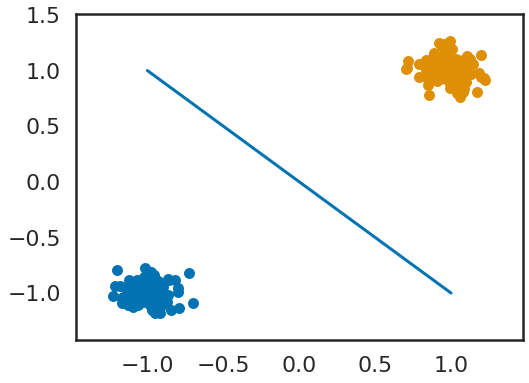

In [23]:
point_1 = [1,-1]
point_2 = [-1,1]
plt.plot(point_1, point_2)
plot_2d(obs_bi_gauss[0], obs_bi_gauss[1])

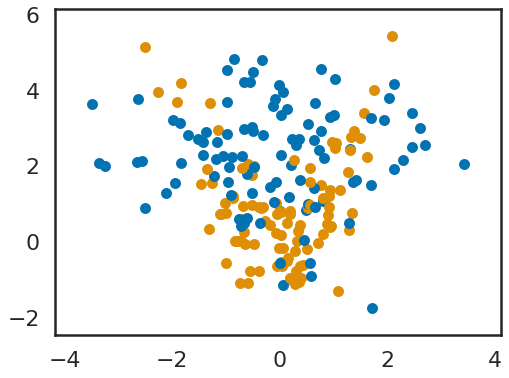

In [24]:
plot_2d(obs_clown[0], obs_clown[1])

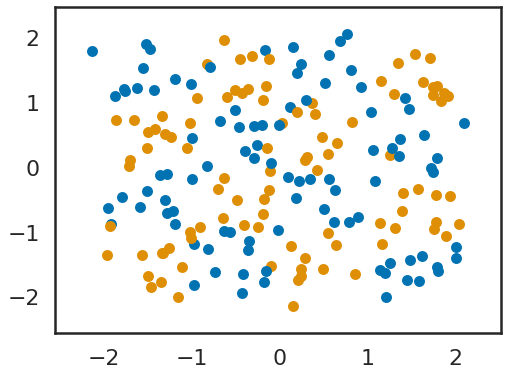

In [25]:
plot_2d(obs_checker[0], obs_checker[1])

### Les classifieurs linéaires (affines)

In [26]:
obs_bi_gauss

(array([[ 0.88576306,  1.15345459],
        [ 1.12756331,  1.10031462],
        [ 0.84499939,  0.86882282],
        [-1.16650376, -1.04603959],
        [ 0.93185311,  1.11283444],
        [-1.01462635, -0.92065602],
        [ 1.17045653,  0.80778507],
        [ 1.016814  ,  0.9758568 ],
        [ 1.04978124,  0.88375872],
        [ 0.84399952,  0.94229965],
        [ 0.94207376,  1.04003007],
        [ 1.18177203,  0.97350061],
        [-1.07770792, -0.99477277],
        [-1.05205317, -1.0147074 ],
        [-0.91319004, -1.11212168],
        [-0.98951733, -0.97403213],
        [-0.96001956, -0.97321852],
        [-1.11207085, -1.09678953],
        [ 1.1985416 ,  0.94465536],
        [-0.92687579, -1.04745733],
        [-0.99628718, -0.89887571],
        [-0.96861663, -1.14834349],
        [ 1.00838708,  0.96446689],
        [-0.91098167, -0.97095305],
        [-1.16370299, -1.043572  ],
        [-1.12977376, -0.93240506],
        [-0.78923587, -1.13059554],
        [-1.16157615, -1.036

In [45]:
w = np.array([0, 2, 2])
prediction = predict(obs_bi_gauss[0], w)
predict_class(obs_bi_gauss[0],w)

array([-1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,
        1., -1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,
        1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.,
        1., -1., -1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.,
        1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,
        1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.,
        1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1

### Fonction de coût

### Quelle est la nature des fonctions

In [46]:
one_loss = zero_one_loss(obs_bi_gauss[0], obs_bi_gauss[1],  w)

In [47]:
h_loss = hinge_loss(obs_bi_gauss[0], obs_bi_gauss[1],  w)

In [48]:
m_loss = mse_loss(obs_bi_gauss[0], obs_bi_gauss[1],  w)

In [49]:
gr_h_loss = gr_hinge_loss(obs_bi_gauss[0], obs_bi_gauss[1],  w)

In [50]:
gr_m_loss = gr_mse_loss(obs_bi_gauss[0], obs_bi_gauss[1],  w)

In [33]:
one_loss.shape

(200,)

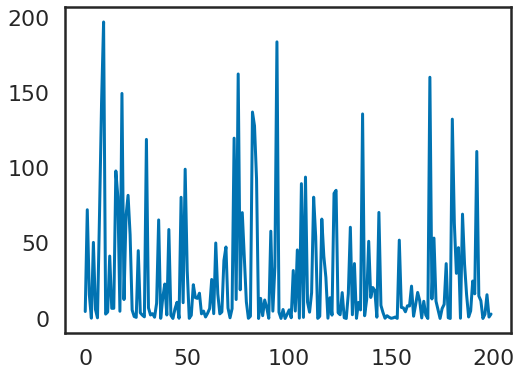

In [53]:
plt.plot(m_loss)

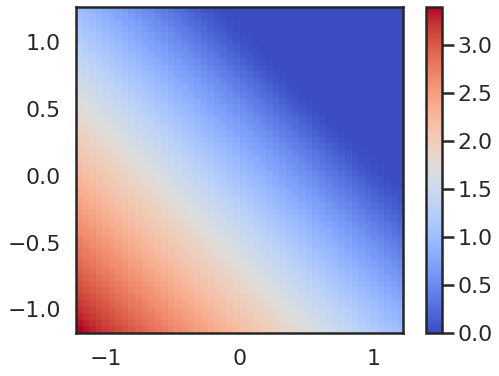

In [35]:
plot_cout(obs_bi_gauss[0], obs_bi_gauss[1], hinge_loss)

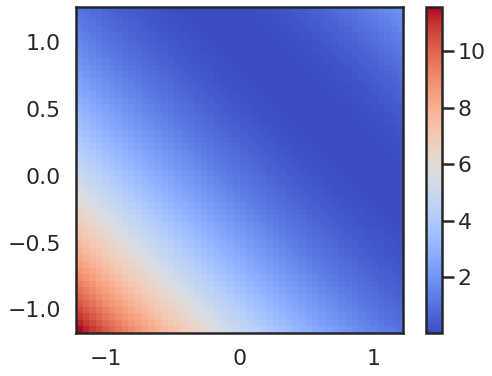

In [36]:
plot_cout(obs_bi_gauss[0], obs_bi_gauss[1], mse_loss)

In [37]:
gradient(obs_bi_gauss[0], obs_bi_gauss[1], 1, 20, w,  hinge_loss, gr_hinge_loss)

(array([[0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]))

In [38]:
gradient(obs_bi_gauss[0], obs_bi_gauss[1], 1, 20, w,  hinge_loss, gr_hinge_loss, False)

(array([[0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.],
        [0., 2., 2.]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]))

In [39]:
t = np.ones((3,1))

In [40]:
t = np.mat((3,1,2))

In [41]:
t

matrix([[3, 1, 2]])

In [42]:
t_ = t.T

In [43]:
w_mat = np.array([0, -2, 2])

In [44]:
plot_cout3d(obs_bi_gauss[0], obs_bi_gauss[1], hinge_loss, w_mat)

IndexError: too many indices for array